## Libraries

In [1]:
# For handling data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# For Outlier Detection
from sklearn.ensemble import IsolationForest

# For Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



## Reading the database ```development.csv```

In [2]:
path = './DSL_Winter_Project_2024/'
df = pd.read_csv(path + 'development.csv')

In [3]:
# Let's see what we have
df.head()

,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,630.348007,-39.715988,580.042799,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,613.880342,-40.679678,580.407491,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,600.714957,-43.206601,579.882635,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,609.723785,-43.570892,590.156125,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824


In [4]:
# Let's split the data into X and y (We have two variables to predict: x and y)
X = df.loc[:, 'pmax[0]':]
y = df[['x', 'y']]

In [5]:
# There is not na data
X.isna().sum().sum()

0

<Axes: >

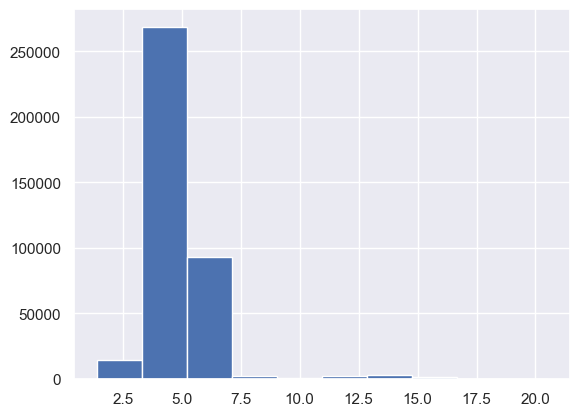

In [6]:
X['pmax[0]'].hist()

<Axes: >

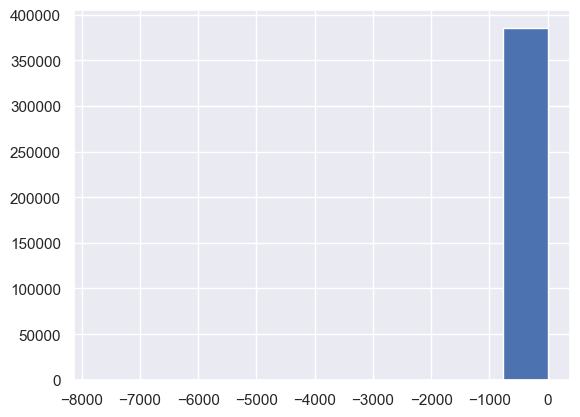

In [7]:
X['negpmax[0]'].hist()

## Correlation data

In [8]:
correlation_matrix = X.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

In [9]:
mask_gt = correlation_matrix >= 0.8 
mask_lt = correlation_matrix <= -0.8

In [10]:
features_correlated = []
for i, row in enumerate(correlation_matrix.index):
    for j, column in enumerate(correlation_matrix.columns):
        if mask_gt.loc[row, column] or mask_lt.loc[row, column]:
            if  i < j:
                features_correlated.append((row, column))
features_correlated

[('pmax[1]', 'area[1]'),
 ('pmax[3]', 'area[3]'),
 ('pmax[4]', 'area[4]'),
 ('pmax[5]', 'negpmax[5]'),
 ('pmax[5]', 'area[5]'),
 ('negpmax[5]', 'area[5]'),
 ('pmax[6]', 'area[6]'),
 ('pmax[8]', 'area[8]'),
 ('pmax[9]', 'area[9]'),
 ('pmax[10]', 'area[10]'),
 ('pmax[11]', 'area[11]'),
 ('pmax[13]', 'area[13]'),
 ('pmax[14]', 'area[14]'),
 ('tmax[15]', 'tmax[16]'),
 ('tmax[15]', 'tmax[17]'),
 ('tmax[16]', 'tmax[17]')]

- Try to delete correlated features and evaluate the performance. (Mateo)
- Train a random forest with X_train and choose the principal features suggested by this model. (Alejandra)

In [5]:
# Let's split X, y into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Let's split X_train_val and y_train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=8)

# Let's reset the indices
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

- Try to delete outliers and evaluate the performance

# Outliers
We have a multivariate problem, so We will detect outliers using Isolation Forest.
We considered the following documentation, for choosing the outlier detector: https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods

In [13]:
isolation_forest = IsolationForest(n_estimators=1000)
X_train['is_outlier'] = isolation_forest.fit_predict(X_train) # fit_predict returns -1 for outliers and 1 for inliers

In [14]:
X_train['is_outlier'].value_counts() 
# 2029 n_estimators=100
# 2809 n_estimators=1000
# 2544 n_estimators=10000

 1    267611
-1      2239
Name: is_outlier, dtype: int64

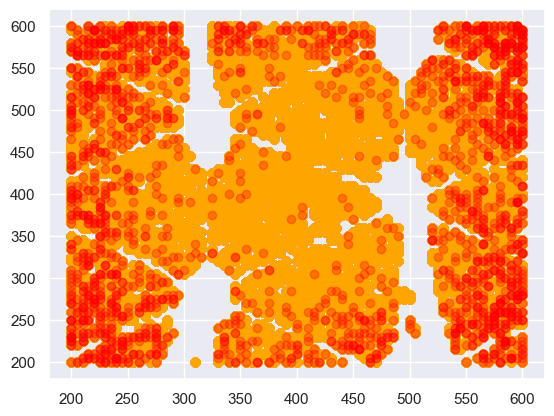

In [15]:
mask_is_outlier = X_train['is_outlier'] == -1
plt.scatter(y_train.x[~mask_is_outlier], y_train.y[~mask_is_outlier], c='orange', label='inliers')
plt.scatter(y_train.x[mask_is_outlier], y_train.y[mask_is_outlier], c='red', label='outliers', alpha=0.3)

plt.show()

In [16]:
X_train_without_outliers, y_train_without_outliers = X_train[~mask_is_outlier], y_train[~mask_is_outlier]
del(X_train_without_outliers['is_outlier'])
del(X_train['is_outlier'])

In [17]:
# Let's reset the index
X_train_without_outliers.reset_index(drop=True, inplace=True)
y_train_without_outliers.reset_index(drop=True, inplace=True)

## Normalization

In [18]:
scaler_without_outliers = StandardScaler()
scaler = StandardScaler()

X_train_without_outliers_scaled = scaler_without_outliers.fit_transform(X_train_without_outliers)
X_train_scaled = scaler.fit_transform(X_train)

In [19]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_without_outliers_scaled = pd.DataFrame(X_train_without_outliers_scaled, columns=X_train.columns)

## PCA

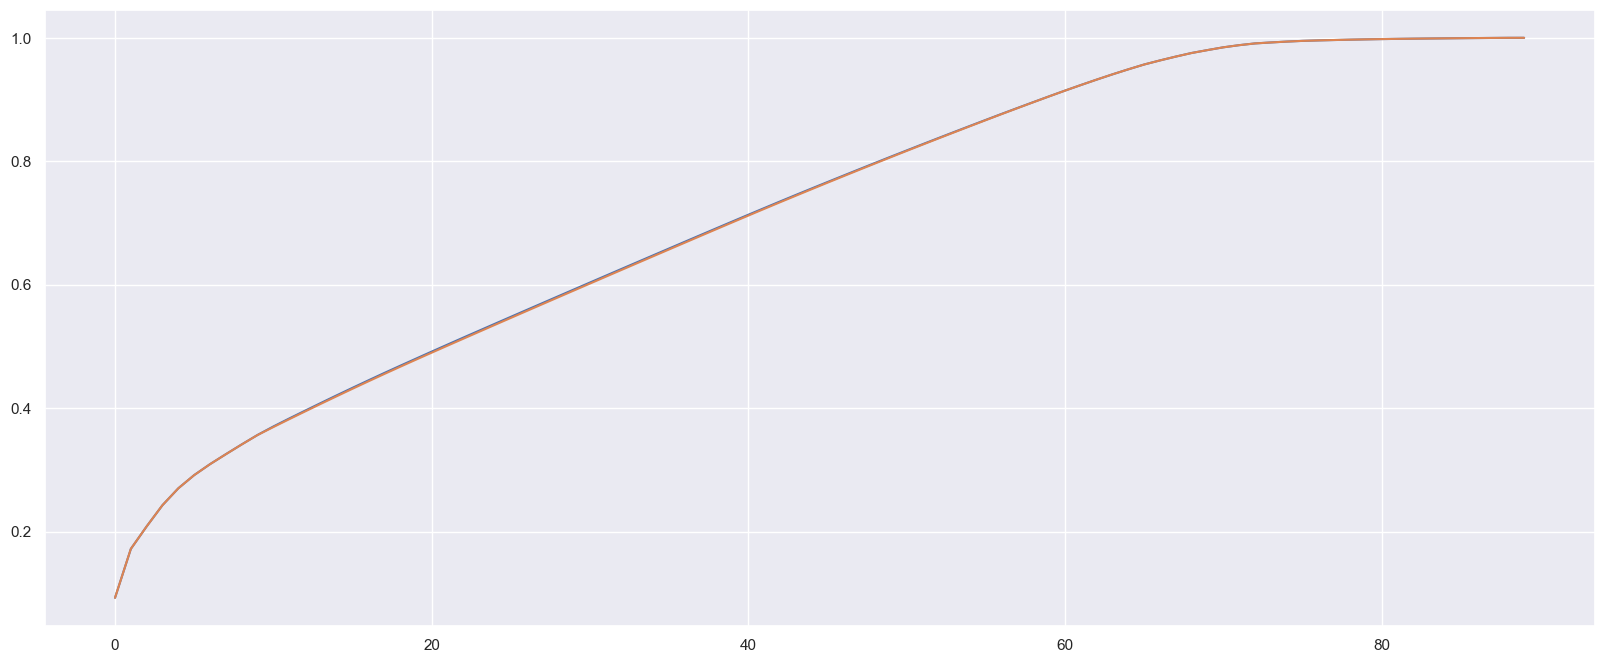

In [20]:
pca = PCA()
pca_without_outliers = PCA()

pca.fit(X_train_scaled)
pca_without_outliers.fit(X_train_without_outliers_scaled)

plt.figure(figsize=(20,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca_without_outliers.explained_variance_ratio_))
# plt.xticks(ticks=np.arange(pca.n_features_), 
#             labels=[f'PC{i + 1}' for i in range(pca.n_features_)])


# plt.figure(figsize=(20,8))
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.title('Xworkdf')
# #plt.ylim([0, 1.1])
# plt.xticks(ticks=np.arange(pca.n_features_), 
#            labels=[f'PC{i + 1}' for i in range(pca.n_features_)])
# plt.xlabel('Principal components')
# plt.ylabel('Cumulative explained variance')
# plt.grid()
# plt.show()

In [21]:
print(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca_without_outliers.explained_variance_ratio_))

[0.09265431 0.17189915 0.20840624 0.24277017 0.2701079  0.29147687
 0.3092045  0.32536225 0.34117631 0.35649147 0.37024946 0.38317385
 0.39580491 0.40830884 0.42069668 0.4328985  0.44492961 0.45683976
 0.46850847 0.48003572 0.49155268 0.50293178 0.51427085 0.52551907
 0.53672811 0.54790585 0.5590589  0.57019881 0.58132065 0.59241924
 0.60350962 0.61456927 0.62561931 0.63665448 0.64766916 0.65867167
 0.66965836 0.68061588 0.69155481 0.70244595 0.71330107 0.72406319
 0.73478183 0.74538089 0.75589097 0.76629629 0.7766554  0.78698371
 0.7972071  0.80739681 0.81748269 0.82752806 0.83749376 0.84740841
 0.85724503 0.86700581 0.87673854 0.88630605 0.89578127 0.90518669
 0.91444404 0.92346204 0.93225638 0.94079499 0.94894872 0.95675644
 0.96336263 0.96959502 0.97542439 0.98011166 0.98459657 0.98807887
 0.9908995  0.99244697 0.99385347 0.99501665 0.99577816 0.99639204
 0.99697366 0.99746321 0.99792591 0.99827968 0.99858783 0.99886432
 0.99911558 0.99936265 0.99958155 0.99977892 0.99997332 1.    

In [22]:
def findm(pca):
        m=0
        for i,var in enumerate(np.cumsum(pca.explained_variance_ratio_)):
                if var>=0.99:        
                        m=i+1 #It is +1 because the counting starts from 0
                        break    
        return m

In [23]:
n = findm(pca)
n_without_outliers = findm(pca_without_outliers)
n
print(f"n = {n} and n_without_outliers = {n_without_outliers}")

n = 73 and n_without_outliers = 73


In [24]:
pca = PCA(n_components=n)
pca_without_outliers = PCA(n_components=n_without_outliers)

pca.fit(X_train_scaled)
pca_without_outliers.fit(X_train_without_outliers_scaled)

PCA(n_components=73)

In [25]:
X_train_pca = pca.transform(X_train_scaled)
X_train_without_outliers_pca = pca_without_outliers.transform(X_train_without_outliers_scaled)

In [26]:
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i + 1}' for i in range(n)])
X_train_without_outliers_pca = pd.DataFrame(X_train_without_outliers_pca, columns=[f'PC{i + 1}' for i in range(n_without_outliers)])

In [27]:
# Download the datasets with outliers and without outliers respectively
pd.concat([X_train, y_train], axis=1).to_csv(path + 'train.csv', index=False)
pd.concat([X_train_without_outliers, y_train_without_outliers], axis=1).to_csv(path + 'train_without_outliers.csv', index=False)

# Download the datasets scaled with outliers and without outliers respectively
pd.concat([X_train_scaled, y_train], axis=1).to_csv(path + 'train_scaled.csv', index=False)
pd.concat([X_train_without_outliers_scaled, y_train_without_outliers], axis=1).to_csv(path + 'train_without_outliers_scaled.csv', index=False)

# Download the datasets scaled and pca with outliers and without outliers respectively
pd.concat([X_train_pca, y_train], axis=1).to_csv(path + 'train_pca.csv', index=False)
pd.concat([X_train_without_outliers_pca, y_train_without_outliers], axis=1).to_csv(path + 'train_without_outliers_pca.csv', index=False)

In [28]:
# Download the test set
pd.concat([X_test, y_test], axis=1).to_csv(path + 'test.csv', index=False)

In [29]:
X_test = pd.read_csv(path + 'evaluation.csv', index_col=0)

In [30]:
X_test.head()

,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],tmax[1],rms[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
Id,,,,,,,,,,,,,,,,,,,,,
0,4.400616,-4.257770,2.860212,176.600000,1.562814,8.738040,-3.598874,5.554105,70.800000,0.729175,...,614.621212,-42.232574,583.237137,70.693530,0.861022,608.931417,-42.728827,568.019556,70.755552,0.328075
1,5.599571,-2.974570,9.400537,90.677386,1.129626,23.460358,-20.616669,17.998419,72.800000,1.258335,...,520.333440,-36.986118,550.540448,72.781390,0.259205,613.671695,-44.449564,586.292097,72.900695,0.401326
2,3.731995,-5.662292,1.930957,155.200000,0.921757,4.837952,-7.224267,3.289124,67.057395,0.793541,...,607.642389,-46.680069,582.825835,71.407320,0.552691,608.996069,-45.877765,589.520958,71.406020,0.343592
3,5.657729,-4.600342,5.593030,30.463179,1.269390,87.293692,-45.786813,38.422989,71.800000,0.733773,...,596.094911,-48.241263,577.835129,72.011986,0.361220,612.500144,-49.572583,583.795426,72.066338,0.429650
4,3.716666,-4.583796,1.946927,33.600000,1.082743,9.593125,-5.374179,7.767408,72.414459,1.572473,...,620.793628,-37.618567,599.834735,72.251813,0.390639,621.557649,-45.189832,600.988676,72.151243,0.358549


In [31]:
X_test_scaled = scaler_without_outliers.transform(X_test)

In [32]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [33]:
X_test_scaled.head()

,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],tmax[1],rms[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,-0.316532,0.059665,-0.421775,1.328843,0.653849,-0.463328,0.157041,-0.586467,-0.217572,-1.787058,...,0.436753,-0.022144,-0.050865,-1.620812,1.359924,-0.008763,1.203690,-2.151972,-1.607005,-0.568859
1,0.497444,0.175226,1.450808,-0.117491,-0.615426,0.416961,-0.325313,0.892171,-0.150770,-0.229731,...,-6.455890,1.640702,-4.967441,1.997425,-0.649341,0.332447,0.709447,0.460931,2.060626,0.406211
2,-0.770463,-0.066822,-0.687833,0.968617,-1.224501,-0.696525,0.054283,-0.855593,-0.342578,-1.597629,...,-0.073414,-1.431763,-0.112713,-0.383823,0.330512,-0.004109,0.299228,0.922646,-0.494875,-0.362311
3,0.536929,0.028814,0.360668,-1.131076,-0.205907,4.233738,-1.038738,3.319025,-0.184171,-1.773527,...,-0.917560,-1.926578,-0.863161,0.664058,-0.308745,0.248117,-0.762027,0.103917,0.634094,0.783253
4,-0.780870,0.030304,-0.683260,-1.078274,-0.752797,-0.412200,0.106722,-0.323481,-0.163648,0.694785,...,0.887970,1.440250,2.444902,1.079675,-0.210524,0.900085,0.496821,2.562485,0.779259,-0.163210


In [34]:
X_test_pca = pca_without_outliers.transform(X_test_scaled)
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i + 1}' for i in range(n_without_outliers)])

In [35]:
X_test_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
0,1.629857,-0.745691,1.760555,-2.381622,1.343619,0.151411,-2.818666,-3.143796,-0.029928,0.914150,...,1.259451,-0.704438,-0.412991,0.323946,-0.323665,-0.378121,-0.288998,0.032386,0.752390,-0.044894
1,1.517629,3.076274,-3.382225,2.852259,-0.278230,-0.402498,-0.135110,1.953874,-1.507724,2.555049,...,0.024746,-0.174890,0.547531,0.507553,0.563004,-0.643301,0.490933,-0.288196,-1.761478,-0.329305
2,-3.724859,-2.209823,-1.496526,-0.859501,-0.697731,1.346715,1.902724,-1.719991,-0.912431,-1.082931,...,-0.604790,-0.663376,-1.364325,1.485729,-0.519272,-1.692171,-0.097181,-0.024450,0.628946,0.878947
3,3.684086,3.711003,-3.588187,0.538536,-0.568730,-0.125194,0.917239,-0.513079,-0.493551,-0.369154,...,-0.460239,0.311280,0.298886,-1.269371,-0.682081,0.412727,1.698919,-1.183571,0.306913,0.033599
4,-0.211798,-1.554031,0.301309,1.873918,1.960946,-0.149730,0.647476,1.002695,0.409701,-0.574692,...,-0.654365,-0.667967,-0.411477,-0.611224,-0.185831,0.070558,0.361773,0.647691,-0.235543,-0.415743


In [36]:
X_test_pca.to_csv(path + 'evaluation_pca.csv', index=True)